# Fashion MNIST Ensemble demo

In this notebook we create an ensemble of three classifiers trained on the Fashion MNIST model and test its accuracy based on fresh images created from a pretrained GAN model.

<img src='https://raw.githubusercontent.com/omarsilloMG/IA5008/master/Homeworks/GAN.png'>

<img src='https://raw.githubusercontent.com/omarsilloMG/IA5008/master/Homeworks/methodology.png'>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Setup the environment

In [ ]:
import tensorflow as tf
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Model definition

Define the generator

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

Helper functions

In [ ]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector.
        In this assignment, this will be the noise vector of shape (n_samples, z_dim),
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    #### START CODE HERE ####
    combined = torch.cat([x,y],dim=1).float()
    #### END CODE HERE ####
    return combined

In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns:
        generator_input_dim: the input dimensionality of the conditional generator,
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim+n_classes
    discriminator_im_chan = n_classes+mnist_shape[0]
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [ ]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    #### START CODE HERE ####
    return F.one_hot(labels,n_classes)
    #### END CODE HERE ####

# Model loading

## Helper functions

In [ ]:
def resize_and_convert2rgb(img):

    IMG_SIZE = 32

    # Convert image type
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    # Convert the grayscale image to RGB
    img = tf.image.grayscale_to_rgb(img)

    # Resize the image to (IMG_SIZE, IMG_SIZE)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # NOTE: Rescaling is omitted as it is often part of the preprocesisng of a pretrained model


    return img

In [ ]:
class LayerScale(tf.keras.layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        init_values (float): value to initialize the diagonal matrix of LayerScale.
        projection_dim (int): projection dimension used in LayerScale.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma

## GAN model

In [ ]:
z_dim = 64
device = 'cuda'
mnist_shape = (1, 28, 28)
n_classes = 10

# Initialize the model, then load state from the checkpoint
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
model_epoch = 500

checkpoint = torch.load(f'/content/gdrive/MyDrive/IA5008/GAN models - 2/checkpoint_{model_epoch}.pt')  # replace 'checkpoint.pt' with the path to your checkpoint
gen.load_state_dict(checkpoint['gen_state_dict'])

<All keys matched successfully>

## Prediction models

In [ ]:
import tensorflow as tf
from keras.models import load_model
import numpy as np

In [ ]:
models_path = '/content/gdrive/Shareddrives/IA5008/Fashion MNIST/Omar/trained_models/'

model1 = load_model(models_path + 'resnet50_best_init_training.h5')
model2 = load_model(models_path + 'simple_cnn_model.h5')
model3 = load_model(models_path + 'convnext_prueba_omar.h5', custom_objects={'LayerScale':LayerScale})

# Sample generation

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Make sure to move the model to eval mode before predicting
gen.eval()

# Generate a batch of noise vectors and class labels
num_images      = 1
fake_noise      = get_noise(num_images, z_dim, device=device)

# ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target_class    = class_names.index('Coat')

one_hot_labels1  = get_one_hot_labels(torch.Tensor([target_class]).long().to(device), n_classes)

In [ ]:
# ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target_class    = class_names.index('Bag')

one_hot_labels2  = get_one_hot_labels(torch.Tensor([target_class]).long().to(device), n_classes)

In [ ]:
#target_label = one_hot_labels1.float()
#target_label = one_hot_labels2.float()
target_label = (one_hot_labels1.float() + one_hot_labels2.float())*0.5

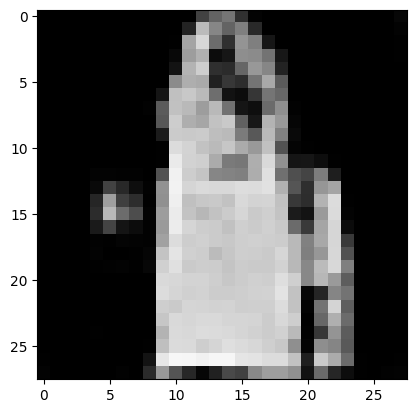

In [ ]:
# Generate the fake images
with torch.no_grad():
    fake = gen(torch.cat([fake_noise, target_label],dim=1))
    #fake = gen(torch.cat([fake_noise*1.0 - 0.5, target_label],dim=1))

show_tensor_images(fake, num_images=num_images)

# Model prediction

In [ ]:
###############################################################################
# Image preprocessing
fake_preprocessed        = (fake + 1.0) * 127.5
fake_preprocessed_uint8  = tf.cast(fake_preprocessed.cpu(), tf.uint8)
img = tf.image.convert_image_dtype(fake_preprocessed_uint8, dtype=tf.float32)
img /= 255.0

# Model 1 image
reshaped_input = np.reshape(img, (-1, 28, 28, 1))

# Model 2 image
reshaped_input2 = resize_and_convert2rgb(reshaped_input)

###############################################################################
# Individual model predictions
pred1                 = model1.predict(reshaped_input)
softmax_predictions1  = tf.nn.softmax(pred1)

pred2                 = model2.predict(reshaped_input)
softmax_predictions2  = tf.nn.softmax(pred2)

pred3                 = model3.predict(reshaped_input2)
softmax_predictions3  = tf.nn.softmax(pred3)

###############################################################################
# Model ensemble
ensemble_prediction       = 0.45*softmax_predictions1 + 0.45*softmax_predictions2 + 0.1*softmax_predictions3
ensemble_prediction_class = np.argmax(ensemble_prediction, axis=1)

predicted_class     = class_names[ensemble_prediction_class[0]]
predicted_class

1/1 [==============================] - 0s 51ms/step


'Coat'

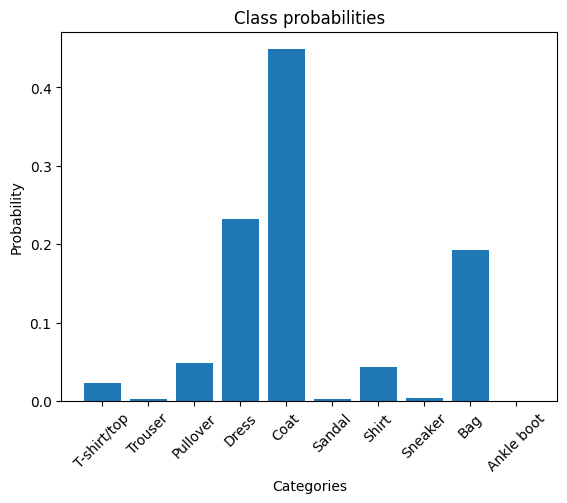

In [ ]:
# Create a barplot
plt.bar(class_names, ensemble_prediction.numpy()[0])

# Set labels and title
plt.xlabel('Categories')
plt.ylabel('Probability')
plt.title('Class probabilities')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()